Dataset loaded with 240387 samples.

        label                                               text
0  BACKGROUND  This study analyzed liver function abnormaliti...
1     RESULTS  A post hoc analysis was conducted with the use...
2     RESULTS  Liver function tests ( LFTs ) were measured at...
3     RESULTS  Survival analyses were used to assess the asso...
4     RESULTS  The percentage of patients with abnormal LFTs ...

Plotting Class Distribution:


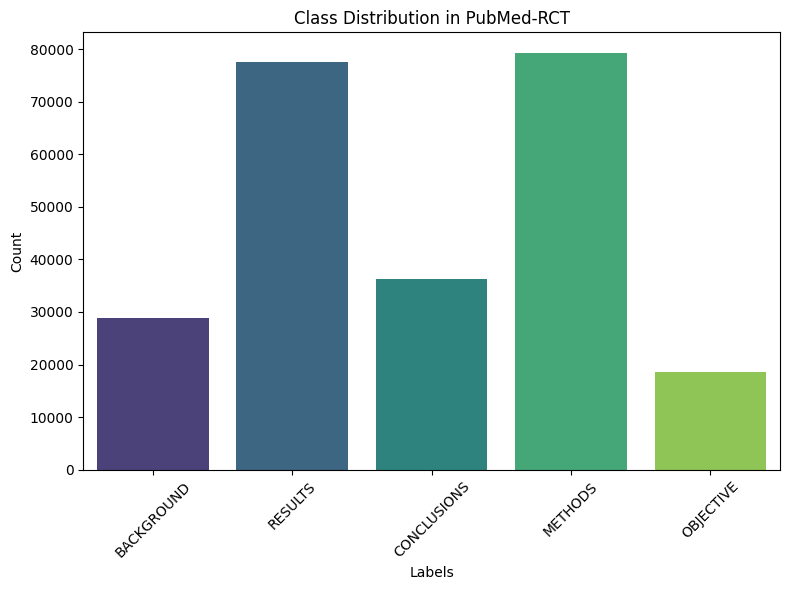


Plotting Token Lenght Distribution:


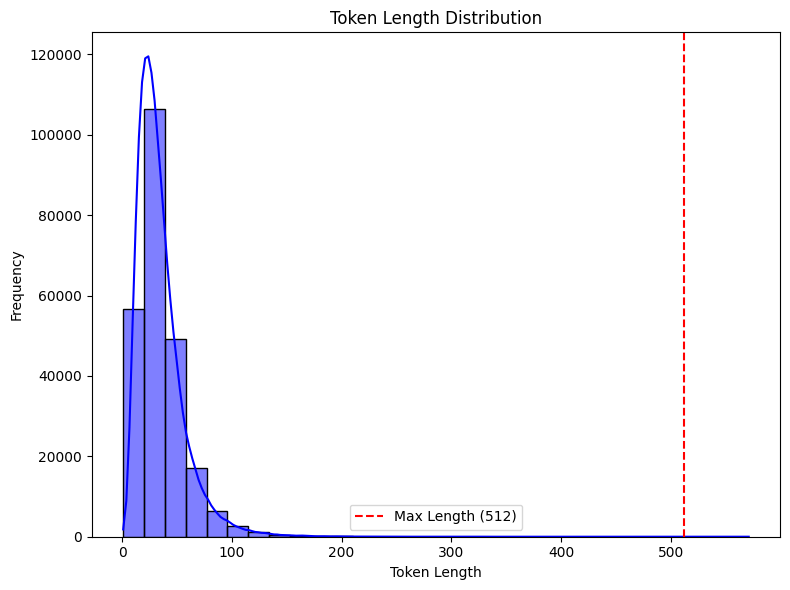


Plotting Most Frequent Words:


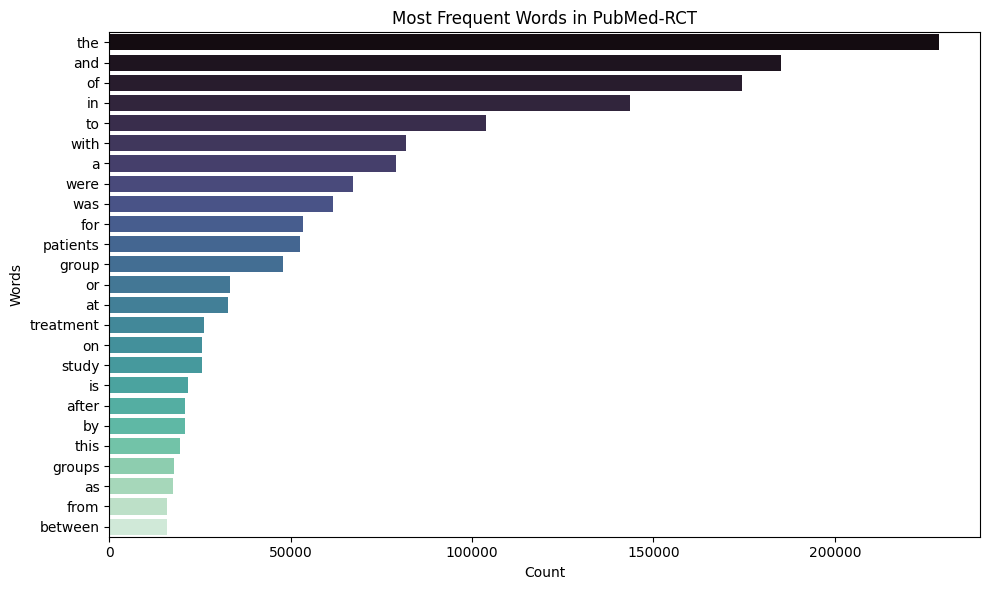


Dataset Splitted:
Train Data: 192309 samples
 - Labeled Data: 19230 samples
 - Unlabeled Data: 173079 samples
Validation Data: 24039 samples
Test Data: 24039 samples

Original Text: This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .
Weak Augmentation: this [MASK] analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .
Strong Augmentation (Synonym Replacement): This survey analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .
Strong Augmentation (Back-Translation): This study analyzed liver function abnormalities in patients with admitted heart failure with severe acute decompensated heart failure (ADHF).

Original Text: A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery C

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

Strong Augmentation (Back-Translation): A posteriori analysis was performed using data from the study to evaluate the efficacy of catheterization of pulmonary arteries and congestive heart failure.

Original Text: Liver function tests ( LFTs ) were measured at 7 time points from baseline , at discharge , and up to 6 months follow-up .
Weak Augmentation: liver function tests ( lfts ) were measured at 7 time points from baseline , at discharge , and up to 6 [MASK] follow - up .
Strong Augmentation (Synonym Replacement): liver function tests ( LFTs ) were measured at 7 time points from baseline , at discharge , and up to 6 months follow-up .
Strong Augmentation (Back-Translation): Liver function tests ( TFT ) were measured at 7 points of time from baseline , at discharge and up to 6 months of follow-up .

Original Text: Survival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and pa

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, MarianMTModel, MarianTokenizer
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
import random

RANDOM_STATE = 2022484
random.seed(RANDOM_STATE)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
file_path = r"X:\Projects\ML\Project\pubmed_rct.txt"

def load_pubmed_rct(file_path):
    cases = []
    with open(file_path, "r", encoding="utf-8") as f:
        case = {"label": None, "text": ""}
        for line in f:
            line = line.strip()
            if line == "":
                if case["label"] and case["text"]:
                    cases.append(case)
                case = {"label": None, "text": ""}
            elif line.split("\t")[0].isupper():
                if case["label"] and case["text"]:
                    cases.append(case)
                parts = line.split("\t")
                case = {"label": parts[0], "text": parts[1]}
            else:
                case["text"] += " " + line.strip()
        if case["label"] and case["text"]:
            cases.append(case)

    df = pd.DataFrame(cases)
    print(f"Dataset loaded with {len(df)} samples.\n")
    print(df.head())
    return df
data = load_pubmed_rct(file_path)

def plot_class_distribution(data):
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data, x="label", palette="viridis", hue="label", dodge=False, legend=False)
    plt.title("Class Distribution in PubMed-RCT")
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
print("\nPlotting Class Distribution:")
plot_class_distribution(data)

def analyze_token_lengths(data, tokenizer, max_length=512):
    token_lengths = data["text"].apply(lambda x: len(tokenizer.tokenize(x)))
    plt.figure(figsize=(8, 6))
    sns.histplot(token_lengths, bins=30, kde=True, color="blue")
    plt.axvline(x=max_length, color="red", linestyle="--", label="Max Length (512)")
    plt.title("Token Length Distribution")
    plt.xlabel("Token Length")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()
    return token_lengths
print("\nPlotting Token Lenght Distribution:")
token_lengths = analyze_token_lengths(data, tokenizer)

def plot_most_frequent_words(data, num_words=25):
    data_copy = data.copy()
    tokenizer = RegexpTokenizer(r'\w+')
    all_words = tokenizer.tokenize(" ".join(data_copy["text"].str.lower()))
    filtered_words = [word for word in all_words if not word.isdigit() and (len(word) > 1 or word in ['i', 'a'])]
    freq_dist = FreqDist(filtered_words)
    common_words = freq_dist.most_common(num_words)
    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=words, palette="mako", hue=words, dodge=False, legend=False)
    plt.title("Most Frequent Words in PubMed-RCT")
    plt.xlabel("Count")
    plt.ylabel("Words")
    plt.tight_layout()
    plt.show()
print("\nPlotting Most Frequent Words:")
plot_most_frequent_words(data)

def split_dataset(data, labeled_ratio=0.1):
    train_data, temp_data = train_test_split(data, test_size=0.2, stratify=data["label"], random_state=RANDOM_STATE)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data["label"], random_state=RANDOM_STATE)
    labeled_data, unlabeled_data = train_test_split(train_data, test_size=1 - labeled_ratio, stratify=train_data["label"], random_state=RANDOM_STATE)
    
    print("\nDataset Splitted:")
    print(f"Train Data: {len(train_data)} samples")
    print(f" - Labeled Data: {len(labeled_data)} samples")
    print(f" - Unlabeled Data: {len(unlabeled_data)} samples")
    print(f"Validation Data: {len(val_data)} samples")
    print(f"Test Data: {len(test_data)} samples")
    
    return labeled_data, unlabeled_data, val_data, test_data
labeled_data, unlabeled_data, val_data, test_data = split_dataset(data)

def augment_text(text, augmentation_type="weak"):
    tokens = tokenizer.tokenize(text)

    if augmentation_type == "weak":
        masked_idx = min(len(tokens) - 1, random.randint(0, len(tokens) - 1))
        tokens[masked_idx] = tokenizer.mask_token
        return tokenizer.convert_tokens_to_string(tokens)

    elif augmentation_type == "synonym":
        words = text.split()
        augmented_words = []
        for word in words:
            if word.replace(".", "").isdigit() or "%" in word or "-" in word:
                augmented_words.append(word)
                continue
            if random.random() < 0.15:
                synonyms = wordnet.synsets(word)
                if synonyms:
                    synonym = synonyms[0].lemmas()[0].name()
                    if synonym != word:
                        augmented_words.append(synonym)
                        continue
            augmented_words.append(word)
        return " ".join(augmented_words)

    elif augmentation_type == "back_translation":
        model_name = "Helsinki-NLP/opus-mt-en-fr"
        tokenizer_src = MarianTokenizer.from_pretrained(model_name)
        model_src = MarianMTModel.from_pretrained(model_name)
        translated = model_src.generate(**tokenizer_src(text, return_tensors="pt", max_length=512, truncation=True))
        translated_text = tokenizer_src.decode(translated[0], skip_special_tokens=True)

        model_name_back = "Helsinki-NLP/opus-mt-fr-en"
        tokenizer_tgt = MarianTokenizer.from_pretrained(model_name_back)
        model_tgt = MarianMTModel.from_pretrained(model_name_back)
        back_translated = model_tgt.generate(**tokenizer_tgt(translated_text, return_tensors="pt", max_length=512, truncation=True))
        return tokenizer_tgt.decode(back_translated[0], skip_special_tokens=True)
    else:
        raise ValueError("Invalid augmentation type. Choose 'weak', 'synonym', or 'back_translation'.")

for i in range(5):
    example_text = data["text"].iloc[i]
    print("\nOriginal Text:", example_text)
    print("Weak Augmentation:", augment_text(example_text, augmentation_type="weak"))
    print("Strong Augmentation (Synonym Replacement):", augment_text(example_text, augmentation_type="synonym"))
    print("Strong Augmentation (Back-Translation):", augment_text(example_text, augmentation_type="back_translation"))